In [7]:
import tensorflow as tf
import keras
from keras.models import load_model
from main import df_val
from metrics import auc_roc
import os
import pandas as pd

CHECKPOINTS_PATH = "../model_checkpoints/"
MODEL_CLASSES= ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity',
                'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                'Support Devices']

def _load_model(checkpoint_name):
	return load_model(CHECKPOINTS_PATH+checkpoint_name, custom_objects={'auc_roc': auc_roc})

img_data_gen = keras.preprocessing.image.ImageDataGenerator(  # rotation_range=7,
    rescale=1 / 255)

val_gen = img_data_gen.flow_from_dataframe(df_val,
                                           directory=None,
                                           x_col='Path',
                                           y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                                                  'Lung Opacity',
                                                  'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                                                  'Atelectasis',
                                                  'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                                                  'Support Devices'],
                                           target_size=(224, 224),
                                           color_mode='grayscale',
                                           class_mode='raw',
                                           batch_size=64,
                                           shuffle=False,
                                           interpolation='box')


Found 234 validated image filenames.


In [74]:

model_checkpoints = os.listdir(CHECKPOINTS_PATH)
#for checkpoint in model_checkpoints:


print("loading model...")
model_file = model_checkpoints[1]
model = _load_model(model_file)
print(f"{model_file} loaded successfully.")

print("Predicting...")
preds = model.predict_generator(val_gen, verbose=1)


loading model...
Success.
Predicting...
4/4 [==============================] - 13s 3s/step


In [76]:
df_preds = pd.DataFrame(preds, columns=MODEL_CLASSES)
df_truth = df_val.iloc[:,5:]

Cardiomegaly auc 0.7600992204110559
Edema auc 0.897119341563786
Consolidation auc 0.8655208804462535
Atelectasis auc 0.8060876623376624
Pleural Effusion auc 0.9106265081776744


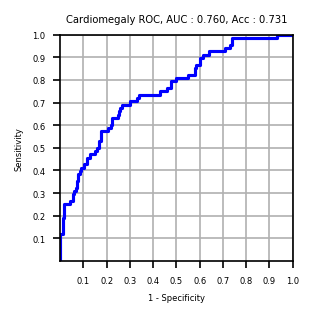

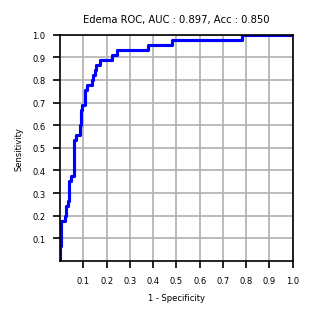

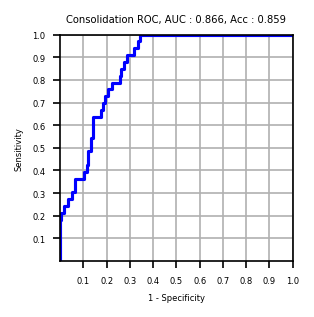

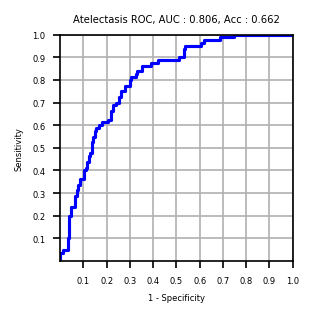

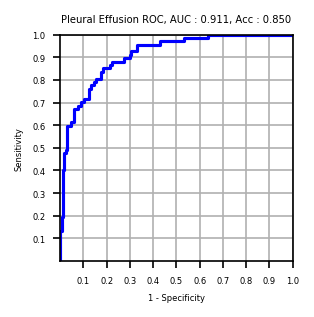

In [77]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_45"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')